<a href="https://colab.research.google.com/github/arkajyotiMukherjee/tensorflow_docs_prac/blob/master/Transfer_Learning_with_tf_Hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

[If you already know what transfertransfer learning is, skip to the next section where we implement transfer learning with Tensorflow Hub]

Transfer Learning in simple terms in basically **reusing** a model developed for one task as a starting point for another model

## Why would you want to use it?

Sometimes you would not want to train a huge model if you can get it pretrained on big datasets like imagenet. Another use case may be when you have a similar task at hand and you would like to use the pretrained model as a starting point and use your own layers on top of it including your own classification layer like a softmax layer with your own labels.

The lower level layers of a model trained on big datasets like ImageNet get pretty good at learning low level image features like shapes and figures and you may want to leverage those in your own image recognizer without making your model learn those representations all over again

## Learning resources

- This video by my favourite ML teacher Andrew Ng should give you enough basic understanding about Transfer Learning to get familier with the problem and understand the objective of the following code implementation.
https://www.youtube.com/watch?v=yofjFQddwHE [**Recommended**]
- This article expands more on the topic of Transfer Learning https://machinelearningmastery.com/transfer-learning-for-deep-learning/


# Transfer Learning with Tensorflow Hub
[This notebook is made from the tensorflow docs with a little of my explaination]

## Installing required libraries

We have installed tensorflow-gpu and tensorflow_hub

In [0]:
%%capture
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow-gpu=2.0.0-beta1
!pip install -q tensorflow_hub

## Importing the required libraries

In [0]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

## Downloading the ImageNet classifier

We can use hub.module to load any [TensorFlow 2 compatible image classifier URL](https://https://tfhub.dev/s?module-type=image-classification&q=tf2) from tfhub.dev and wrap it in a wrap it as a keras layer using hub.KerasLayer()

We also need to specify the input shape for the model

PS: The model we are using here is a "mobilenet_v2" pretrained in the ImageNet dataset

In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [0]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

## Trying on a single image

Let's first try the model on a single image

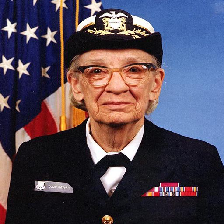

In [0]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

Normalize the image

In [0]:
grace_hopper = np.array(grace_hopper)/255
grace_hopper.shape

(224, 224, 3)

Now we add a new dimension/axis to the image for the batch no and pass the image to our model

In [0]:
results = classifier.predict(grace_hopper[np.newaxis, ...])
results

array([[ 0.17920303,  1.2696182 , -0.3149821 , ...,  0.6060541 ,
        -0.4299778 ,  0.11200593]], dtype=float32)

The result is a 1001 vector of logits rating the probability of each class for the image

The top class ID can be found by argmax

In [0]:
predicted_class = np.argmax(results[0], axis=-1)
predicted_class

653

## Decoding the predictions

Now that we have predicted the class ID with the highest probability we need to get the image net labels and decode the image net predictions

You can get the labels from the following link or if you prefer you can use any other source

ImageNet labels:
https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt

In [0]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
imagenet_labels

array(['background', 'tench', 'goldfish', ..., 'bolete', 'ear',
       'toilet tissue'], dtype='<U30')

Let's plot the image with the predicted label

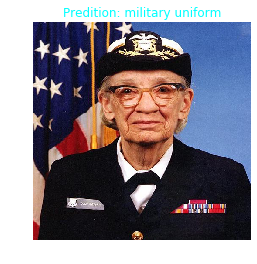

In [0]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title('Predition: '+ predicted_class_name, color='cyan')

## Simple Transfer Learning

Now that you know how to use tensorflow hub to load a model and make predictions, let's try to do some transfer learning with this.

Using tf hub it's easy to retrain the top layer (the one classifying the images into 1000 imagenet labels) of the model to recognize the classes from our dataset

## Loading the Dataset

We will be using the tensorflow flower dataset in this example

In [0]:
data_root = tf.keras.utils.get_file('flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

One simple way to load image data into our model is by using [tf.keras.preprocessing.image.ImageDataGenerator](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

All of TensorFlow Hub's image modules expect float inputs in the [0, 1] range. We will use ImageDataGenerator's rescale parameter to achieve this.

In [0]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


The resulting is an iterator that returns image_batch and label_batch pairs

In [0]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


Now we have got one batch of size 32 of the flower image dataset and 32 of its labels

## Run the classifier on the batch of images

In [0]:
results_batch = classifier.predict(image_batch)
results_batch.shape

(32, 1001)

In [0]:
predicted_class_names = imagenet_labels[np.argmax(results_batch, axis=-1)]
predicted_class_names

array(['white stork', 'daisy', 'pinwheel', 'chime', 'daisy', 'daisy',
       'cardoon', 'daisy', 'daisy', 'greenhouse', 'hip', 'picket fence',
       'lakeside', 'picket fence', 'pot', 'hip', 'cardoon', 'daisy',
       'hip', 'limpkin', "yellow lady's slipper", 'bee', 'bee',
       'feather boa', 'bakery', 'daisy', 'pot', 'daisy', 'ice lolly',
       'daisy', 'picket fence', 'barn spider'], dtype='<U30')

**Now** let's plot the predicted labels with the images of the batch

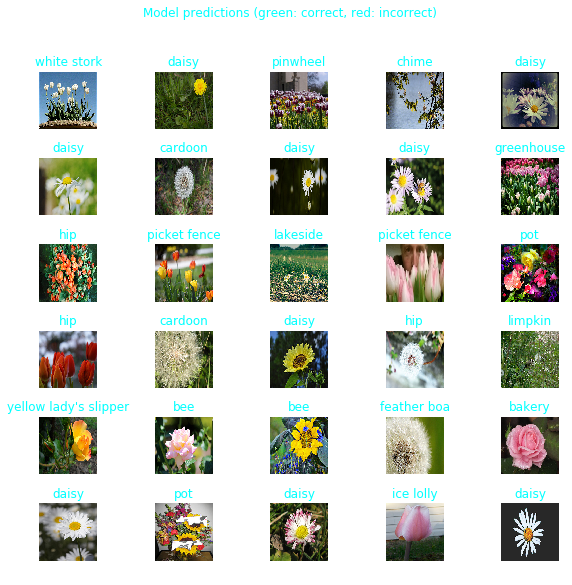

In [0]:
plt.figure(figsize = (10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n], color='cyan')
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)", color='cyan')

The results are clearly way off considering the model was not trained on these labels (except daisy)

## Downloading a headless model

Tensorflow Hub lets you download models without the top classification layer which can then be used for transfer learning

Any [Tensorflow 2 compatible image feature vector URL](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) from tfhub.dev will work here.

In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

Create the feature extractor

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=IMAGE_SHAPE+(3,))

In [0]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


This returns a 1280 length vector for each image. This is effectively the representation of the image.


Now we want would like to keep the weights up to the feature extractor layer and only train our classification layer that we will add on top of this. This saves big time on the computation as we dont have to train the network again only the layers we have added to it and still take the benefits of the pretrained layers.

In [0]:
feature_extractor_layer.trainable = False

## Attach our own layers

We wrap the feature extractor layer in tf.keras.Sequential and add our own layers on top of it.

In this example, we will only add a new softmax classification layer

In [0]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the model

Compile the model by setting the type of optimizer and loss functions and the metrics you would like to evaluate. Here we are using Adam optimizer, categorical cross-entropy as loss function and accuracy as metrics.

In [0]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

Now we train the model with .fit

We can also set up a custom callback to store the loss and accuracy of each batch, instead of the epoch average and later use this to visualize our model's performance.

In [0]:
class ConnectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_train_batch_end(self, batch, logs=False):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['accuracy'])
    self.model.reset_metrics()

In [0]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = ConnectBatchStats()

history = model.fit(image_data,
                   epochs = 15,
                   steps_per_epoch = steps_per_epoch,
                   callbacks = [batch_stats_callback])

Epoch 1/15


W0624 21:40:59.422694 140693999007616 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


115/115 [==============================] - 24s 210ms/step - loss: 0.9431 - accuracy: 0.8438
Epoch 2/15
115/115 [==============================] - 20s 178ms/step - loss: 0.5415 - accuracy: 0.8438
Epoch 3/15
115/115 [==============================] - 23s 199ms/step - loss: 0.4695 - accuracy: 0.8750
Epoch 4/15
115/115 [==============================] - 23s 201ms/step - loss: 0.4136 - accuracy: 0.9062
Epoch 5/15
115/115 [==============================] - 23s 201ms/step - loss: 0.3927 - accuracy: 0.9062
Epoch 6/15
115/115 [==============================] - 23s 201ms/step - loss: 0.3761 - accuracy: 0.9375
Epoch 7/15
115/115 [==============================] - 23s 201ms/step - loss: 0.3557 - accuracy: 0.9062
Epoch 8/15
115/115 [==============================] - 23s 201ms/step - loss: 0.3540 - accuracy: 0.8438
Epoch 9/15
115/115 [==============================] - 23s 201ms/step - loss: 0.3337 - accuracy: 0.8750
Epoch 10/15
115/115 [==============================] - 23s 201ms/step - loss: 0.3052

## Plotting the model's loss and accuracy

We will use matplotlib to plot the accuracy and loss that we have stored during the training process through the callback function.

### Plotting the loss

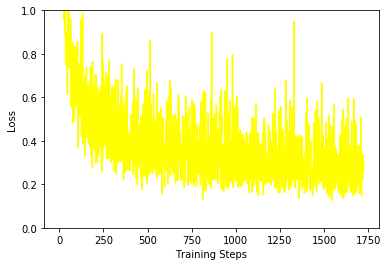

In [0]:
plt.figure()
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.plot(batch_stats_callback.batch_losses, color='yellow')

### Plotting the accuracy

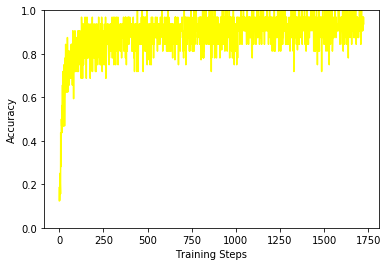

In [0]:
plt.figure()
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.plot(batch_stats_callback.batch_acc, color='yellow')

## Check the predictions

We will redo the plot from before but this will mark wrongly labeled images as red and correctly labeled ones as green. We need the ordered class names for that, so let's extract those.

In [0]:
class_names = sorted(image_data.class_indices.items(), key = lambda pair : pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

We sort the class_indices by their class values (0,1,2,3,4) and then extract the actual names of the flowers

## Predict

Now we make predictions and convert the indices to class names

In [0]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

We also extract the label ids of the flowers from the batch

In [0]:
label_id = np.argmax(label_batch, axis=-1)

## Plot the images

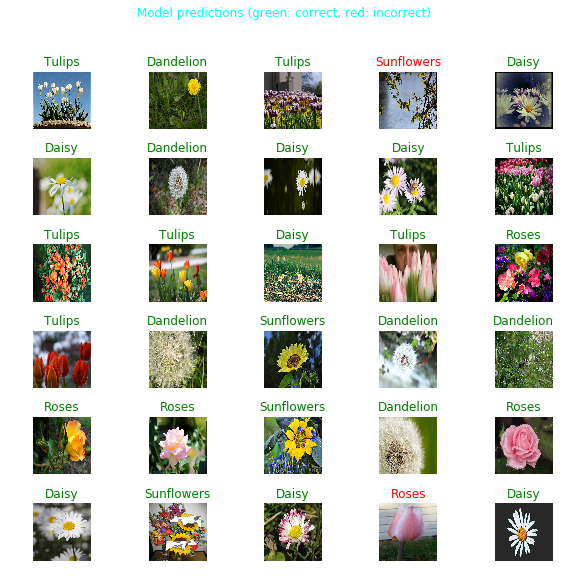

In [0]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.imshow(image_batch[n])
  color = 'green' if predicted_id[n] == label_id[n] else 'red'
  plt.title(predicted_label_batch[n], color = color)
  plt.axis('off')

_=plt.suptitle('Model predictions (green: correct, red: incorrect)', color='cyan')

## Export Model

Now that we have seen our model working nearly perfectly we could export it as a saved model

In [0]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.experimental.export_saved_model(model, export_path)

export_path

W0624 21:46:57.710192 140693999007616 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:253: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
W0624 21:46:57.714830 140693999007616 export_utils.py:182] Export includes no default signature!
W0624 21:46:58.841591 140693999007616 meta_graph.py:450] Issue encountered when serializing variables.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
W0624 21:47:06.702704 140693999007616 export_utils.py:182] Export includes no default signature!
W0624 21:47:07.542383 140693999007616 m

'/tmp/saved_models/1561412809'

Now we can confirm that if we load the model it'll give the same result

In [0]:
reloaded = tf.keras.experimental.load_from_saved_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

abs(reloaded_result_batch - result_batch).max()

Exception ignored in: <bound method _CheckpointRestoreCoordinator.__del__ of <tensorflow.python.training.tracking.util._CheckpointRestoreCoordinator object at 0x7ff50edf2f98>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/util.py", line 244, in __del__
    .format(pretty_printer.node_names[node_id]))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/util.py", line 93, in node_names
    path_to_root[node_id] + (child.local_name,))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/object_identity.py", line 76, in __getitem__
    return self._storage[self._wrap_key(key)]
KeyError: (<tensorflow.python.training.tracking.object_identity._ObjectIdentityWrapper object at 0x7ff5076e0128>,)


0.0

I hope you have understood Transfer Learning in tensorflow with tf hub. This code is from the [tensorflow docs](https://www.tensorflow.org/beta/tutorials/images/hub_with_keras). I have just given my own explationation in parts where I had problems understanding the 1st time in the hope if someone reads the code of the docs and doesn't understand they have some source to refer to.